In this notebook we simulate 500 cells with 100 non-rhythmic genes and 12 rhythmic genes. The stock Louvain is clustering based on the nearest neighbors graph from all genes. My algorithm includes the ccd metric calculated from just the 12 core clock rhythmic genes. Here I modify the reference matrix to include more of these "cry1-like" genes. This may help merge the two sides of the circle.

In [1]:
import scanpy as sc
import numpy as np
import pandas as pd
import anndata as ad
from anndata import AnnData

import random
import leidenalg
import louvain
import time

**Create Non_rhythmic Genes**

In [2]:

# Set random seed for reproducibility
random.seed(42)
np.random.seed(42)

# Create an AnnData object
adata = sc.AnnData()

# Define the number of cells and genes
n_cells = 500
n_genes = 100


num_cell_types = 2

# Generate a list of random numbers same dim as num_cell_types
random_numbers = np.random.rand(num_cell_types)

# Repeat each string n times
offsets = random.choices(random_numbers, k=n_cells)
# Simulate gene expression data
gene_expression_data = np.random.gamma(shape=1, scale=1, size=(n_cells, n_genes)) 
for i in range(n_genes):
    gene_expression_data[:,i] += (np.array(offsets)*15)
# Create an AnnData object with the simulated data
adata = sc.AnnData(X=gene_expression_data)


**Create Rhythmic Genes**

In [3]:
np.random.seed(42)

# Generate gene expression data for 10 genes from a cosine wave
n_cells = adata.shape[0]
n_new_genes = 12
new_gene_names = [f'NewGene_{i}' for i in range(n_genes+1, n_genes+n_new_genes + 1)]


# Create a cosine wave for each gene
gene_expression_data = np.zeros((n_cells, n_new_genes))
for i in range(n_new_genes):
    # phase = np.random.uniform(0, 2 * np.pi)
    if i < 3:
        phase = np.random.uniform(-.5, .5)
    elif (i in [3, 4]):
        phase =  np.random.uniform(3*np.pi/2-.5, 3*np.pi/2+ .5)
    else:
        phase = np.random.uniform(np.pi-.5, np.pi+.5)

    amp = np.random.uniform(10, 20) #number between 10-20
    noise = np.random.normal(0, 1, n_cells)
    freq = np.pi*2/n_cells
    gene_expression_data[:, i] = amp  *  np.cos(freq * np.arange(n_cells) - phase ) + (np.array(offsets)*8) #+ noise
    


# Create a new AnnData object for the new genes
new_genes_adata = ad.AnnData(X=gene_expression_data, var=pd.DataFrame(index=new_gene_names))

# Concatenate the new genes with the existing adata
adata2 = ad.concat([adata, new_genes_adata], axis = 1)

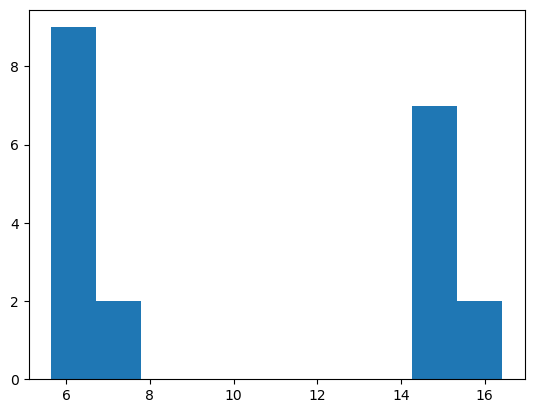

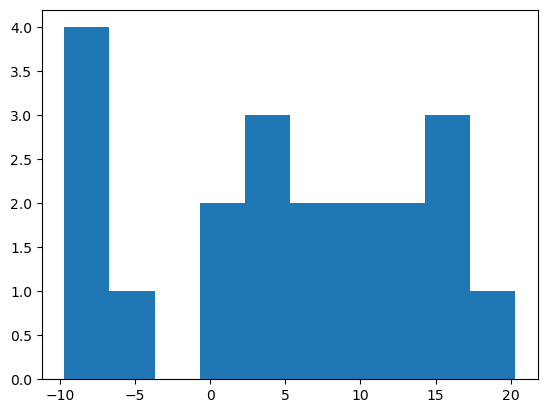

In [4]:
import matplotlib.pyplot as plt
import numpy as np

plt.hist(adata2.X[:, 0])
plt.show()


plt.hist(adata2.X[:, 111])
plt.show()

**Plot Synthetic Genes**

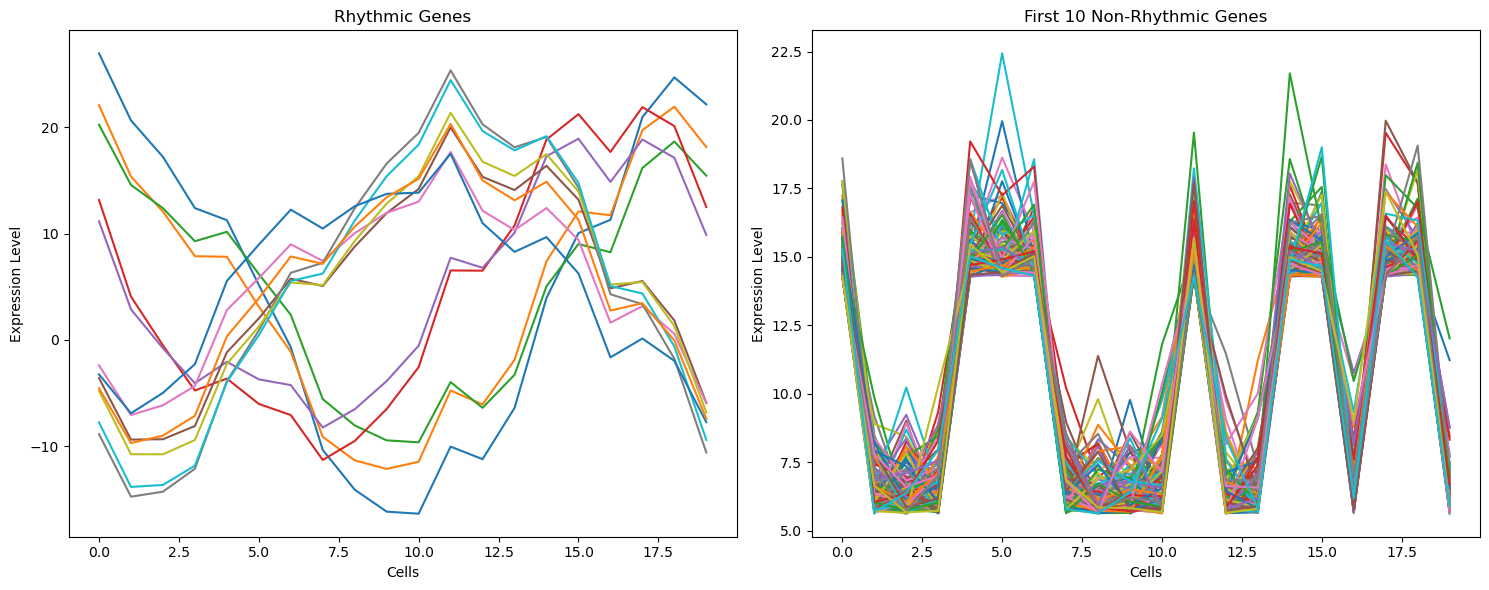

In [5]:
import matplotlib.pyplot as plt

# Create a figure with two subplots (1 row, 2 columns)
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Plot rhythmic genes
axes[0].set_title('Rhythmic Genes')
for i in range(n_genes, n_genes+n_new_genes):
    axes[0].plot( adata2.X[:, i], label=f'Gene_{i + 1}')
axes[0].set_xlabel('Cells')
axes[0].set_ylabel('Expression Level')

# Plot non-rhythmic genes
axes[1].set_title('First 10 Non-Rhythmic Genes')
for i in range(0, n_genes):
    axes[1].plot(adata2.X[:, i], label=f'Gene_{i + 1}')
axes[1].set_xlabel('Cells')
axes[1].set_ylabel('Expression Level')
#axes[1].legend()

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

In [6]:
cell_identities = [f'batch_{i:.2f}' for i in offsets]
# Number of times each string should be repeated
# n = int(n_cells/num_cell_types)

# # Repeat each string n times
# result = [s for s in strings for _ in range(n)]
# cell_identities = result + result
# cell_identities = cell_identities[0:n_cells]
assert(len(cell_identities) == n_cells)

/opt/miniconda3/envs/native/lib/python3.12/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/opt/miniconda3/envs/native/lib/python3.12/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/opt/miniconda3/envs/native/lib/python3.12/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/opt

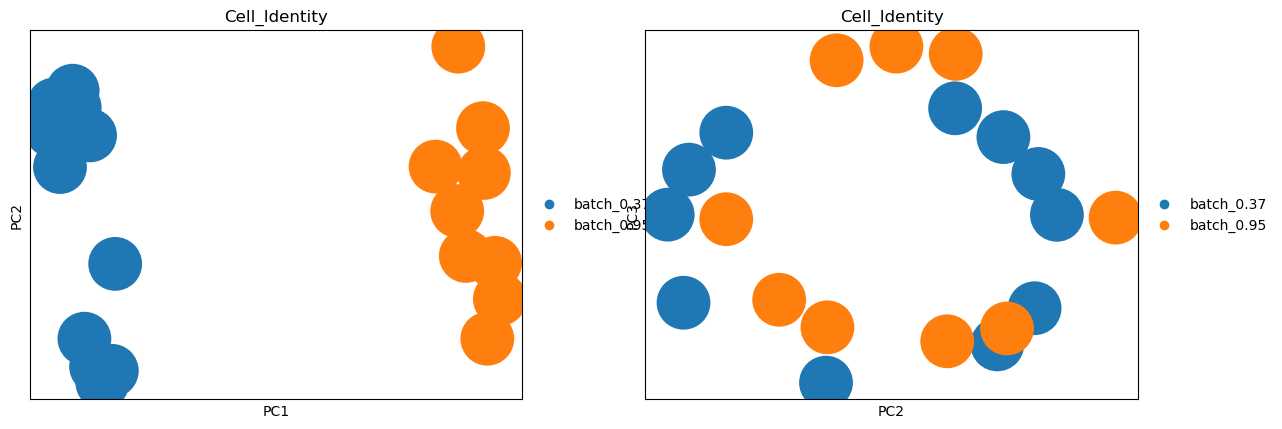

/opt/miniconda3/envs/native/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
# Perform PCA
sc.tl.pca(adata2)

# Generate random cell identities
#cell_identities = np.random.choice(['Type_A', 'Type_B', 'Type_C'], size=adata2.shape[0])

# # Determine quantiles based on PC3 values
# quantiles = np.percentile(adata2.obsm['X_pca'][:, 2], [0, 25, 50, 75, 100])
# pd.cut(adata2.varm['PCs'][:, 2], bins=[-np.inf] + list(quantiles) + [np.inf], labels=['Type_A', 'Type_B', 'Type_C', 'Type_D', 'Type_E','Type_F'])

# # Assign cell identities based on quantiles
# cell_identities = pd.cut(adata2.obsm['X_pca'][:, 2], bins=[-np.inf] + list(quantiles) + [np.inf], labels=['Type_A', 'Type_B', 'Type_C', 'Type_D', 'Type_E','Type_F'])

#Make cell identities on distant side of clock

# Add the 'Cell_Identity' column to adata.obs
adata2.obs['Cell_Identity'] = cell_identities
adata2.obs['time'] = np.arange(0, n_cells)
# Specify the PCs you want to plot (e.g., PC2, PC3)
pcs_to_plot = ['1,2', '2,3']

# Plot PCA for the selected PCs
sc.pl.pca(adata2, color='Cell_Identity', components=pcs_to_plot, show=True)
# Preprocess the data (e.g., log-transform and scale)
sc.pp.scale(adata2)

# Calculate the neighborhood graph
sc.pp.neighbors(adata2, n_neighbors=10, n_pcs=10)  # Adjust parameters as needed
# adata2.obsp["connectivities"]


In [8]:
from random import randint
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import igraph
def _plot(g, membership=None, draw = "kk"):
    layouts = ["circle", "drl", "fr", "kk", "fr3d", "kk3d", "large", "lgl", "random", "rt", "tree", "rt_circular", "sphere"]
    if draw not in layouts:
        print("sorry, {} not viable layout option.".format(draw))
        return
    if membership is not None:
        gcopy = g.copy()
        edges = []
        edges_colors = []
        for edge in g.es():
            if membership[edge.tuple[0]] != membership[edge.tuple[1]]:
                edges.append(edge)
                edges_colors.append("gray")
            else:
                edges_colors.append("black")
        gcopy.delete_edges(edges)
        layout = gcopy.layout(draw)
        g.es["color"] = edges_colors
    else:
        layout = g.layout(draw)
        g.es["color"] = "gray"
    visual_style = {}
    visual_style["vertex_label_dist"] = 0
    visual_style["vertex_shape"] = "circle"
    visual_style["edge_color"] = g.es["color"]
    # visual_style["bbox"] = (4000, 2500)
    visual_style["vertex_size"] = 15
    visual_style["layout"] = gcopy.layout(draw)
    visual_style["bbox"] = (1024, 768)
    visual_style["margin"] = 40
    #visual_style["edge_label"] = g.es["weight"]
    for vertex in g.vs():
        vertex["label"] = vertex.index
    if membership is not None:
        colors = []
        for i in range(0, max(membership)+1):
            colors.append('%06X' % randint(0, 0xFFFFFF))
        for vertex in g.vs():
            vertex["color"] = str('#') + colors[membership[vertex.index]]
        visual_style["vertex_color"] = g.vs["color"]
    fig, ax = plt.subplots()
    igraph.plot(g, target = ax, **visual_style)

In [9]:
from scanpy import _utils
import importlib
import warnings
from scanpy import logging as logg
from scipy import sparse
# from scanpy.tools._compat import old_positionals
from scanpy._utils import _choose_graph
from scanpy.tools._utils_clustering import rename_groups, restrict_adjacency
from natsort import natsorted
from collections.abc import Sequence
from types import MappingProxyType
from scipy.sparse import spmatrix
from collections.abc import Mapping, Sequence

try:
    from leidenalg.VertexPartition import MutableVertexPartition
except ImportError:

    class MutableVertexPartition:
        pass

    MutableVertexPartition.__module__ = "leidenalg.VertexPartition"
try:
    from louvain.VertexPartition import MutableVertexPartition
except ImportError:

    class MutableVertexPartition:
        pass

    MutableVertexPartition.__module__ = "louvain.VertexPartition"

from typing import TYPE_CHECKING, Literal, Any

#interface my custom clustering with scanpy:
def ccdCluster_leiden(
    adata: AnnData,
    emat,
    refmat,
    resolution: float = 1,
    *,
    restrict_to: tuple[str, Sequence[str]] | None = None,
    random_state: _utils.AnyRandom = 0,
    key_added: str = "louvainccd",
    adjacency: sparse.spmatrix | None = None,
    directed: bool | None = None,
    use_weights: bool = True,
    n_iterations: int = -1,
    partition_type: type[MutableVertexPartition] | None = None,
    neighbors_key: str | None = None,
    obsp: str | None = None,
    copy: bool = False,
    flavor: Literal["leidenalg", "ipgraph"] = "leidenalg",
    **clustering_args,
) -> AnnData | None:
    """\
    Cluster cells into subgroups [Traag18]_.

    Cluster cells using the Leiden algorithm [Traag18]_,
    an improved version of the Louvain algorithm [Blondel08]_.
    It has been proposed for single-cell analysis by [Levine15]_.

    This requires having ran :func:`~scanpy.pp.neighbors` or
    :func:`~scanpy.external.pp.bbknn` first.

    Parameters
    ----------
    adata
        The annotated data matrix.
    resolution
        A parameter value controlling the coarseness of the clustering.
        Higher values lead to more clusters.
        Set to `None` if overriding `partition_type`
        to one that doesn’t accept a `resolution_parameter`.
    random_state
        Change the initialization of the optimization.
    restrict_to
        Restrict the clustering to the categories within the key for sample
        annotation, tuple needs to contain `(obs_key, list_of_categories)`.
    key_added
        `adata.obs` key under which to add the cluster labels.
    adjacency
        Sparse adjacency matrix of the graph, defaults to neighbors connectivities.
    directed
        Whether to treat the graph as directed or undirected.
    use_weights
        If `True`, edge weights from the graph are used in the computation
        (placing more emphasis on stronger edges).
    n_iterations
        How many iterations of the Leiden clustering algorithm to perform.
        Positive values above 2 define the total number of iterations to perform,
        -1 has the algorithm run until it reaches its optimal clustering.
        2 is faster and the default for underlying packages.
    partition_type
        Type of partition to use.
        Defaults to :class:`~leidenalg.RBConfigurationVertexPartition`.
        For the available options, consult the documentation for
        :func:`~leidenalg.find_partition`.
    neighbors_key
        Use neighbors connectivities as adjacency.
        If not specified, leiden looks .obsp['connectivities'] for connectivities
        (default storage place for pp.neighbors).
        If specified, leiden looks
        .obsp[.uns[neighbors_key]['connectivities_key']] for connectivities.
    obsp
        Use .obsp[obsp] as adjacency. You can't specify both
        `obsp` and `neighbors_key` at the same time.
    copy
        Whether to copy `adata` or modify it inplace.
    flavor
        Which package's implementation to use.
    **clustering_args
        Any further arguments to pass to :func:`~leidenalg.find_partition` (which in turn passes arguments to the `partition_type`)
        or :meth:`igraph.Graph.community_leiden` from `igraph`.

    Returns
    -------
    Returns `None` if `copy=False`, else returns an `AnnData` object. Sets the following fields:

    `adata.obs['leiden' | key_added]` : :class:`pandas.Series` (dtype ``category``)
        Array of dim (number of samples) that stores the subgroup id
        (``'0'``, ``'1'``, ...) for each cell.

    `adata.uns['leiden']['params']` : :class:`dict`
        A dict with the values for the parameters `resolution`, `random_state`,
        and `n_iterations`.
    """
    if flavor not in {"igraph", "leidenalg"}:
        raise ValueError(
            f"flavor must be either 'igraph' or 'leidenalg', but '{flavor}' was passed"
        )
    igraph_spec = importlib.util.find_spec("igraph")
    if igraph_spec is None:
        raise ImportError(
            "Please install the igraph package: `conda install -c conda-forge igraph` or `pip3 install igraph`."
        )
    if flavor == "igraph":
        if directed:
            raise ValueError(
                "Cannot use igraph's leiden implemntation with a directed graph."
            )
        if partition_type is not None:
            raise ValueError(
                "Do not pass in partition_type argument when using igraph."
            )
    else:
        try:
            import leidenalg

            msg = 'Use of leidenalg is discouraged and will be deprecated in the future.  Please use `flavor="igraph"` `n_iterations=2` to achieve similar results.  `directed` must also be `False` to work with `igraph`\'s implementation.'
            warnings.warn(msg, FutureWarning)
        except ImportError:
            raise ImportError(
                "Please install the leiden algorithm: `conda install -c conda-forge leidenalg` or `pip3 install leidenalg`."
            )
    clustering_args = dict(clustering_args)

    start = logg.info("running Leiden ccd clustering")
    adata = adata.copy() if copy else adata
    # are we clustering a user-provided graph or the default AnnData one?
    if adjacency is None:
        adjacency = _utils._choose_graph(adata, obsp, neighbors_key)
    if restrict_to is not None:
        restrict_key, restrict_categories = restrict_to
        adjacency, restrict_indices = restrict_adjacency(
            adata,
            restrict_key,
            restrict_categories=restrict_categories,
            adjacency=adjacency,
        )
    # Prepare find_partition arguments as a dictionary,
    # appending to whatever the user provided. It needs to be this way
    # as this allows for the accounting of a None resolution
    # (in the case of a partition variant that doesn't take it on input)
    clustering_args["n_iterations"] = n_iterations
    #if resolution is not None:
        #clustering_args["resolution_parameter"] = resolution
    if flavor == "leidenalg":
        directed = True if directed is None else directed
        g = _utils.get_igraph_from_adjacency(adjacency, directed=directed)
        if partition_type is None:
            partition_type = leidenalg.ccdModularityVertexPartition
        if use_weights:
            clustering_args["weights"] = np.array(g.es["weight"]).astype(np.float64)
        clustering_args["seed"] = random_state
        part = leidenalg.find_partition(g, partition_type, emat, refmat, **clustering_args)
    else:
        g = _utils.get_igraph_from_adjacency(adjacency, directed=False)
        if use_weights:
            clustering_args["weights"] = "weight"
        clustering_args.setdefault("objective_function", "modularity")
        with _utils.set_igraph_random_state(random_state):
            part = g.community_leiden(**clustering_args)
    # store output into adata.obs
    groups = np.array(part.membership)
    if restrict_to is not None:
        if key_added == "leidenccd":
            key_added += "_R"
        groups = rename_groups(
            adata,
            key_added=key_added,
            restrict_key=restrict_key,
            restrict_categories=restrict_categories,
            restrict_indices=restrict_indices,
            groups=groups,
        )
    adata.obs[key_added] = pd.Categorical(
        values=groups.astype("U"),
        categories=natsorted(map(str, np.unique(groups))),
    )
    # store information on the clustering parameters
    adata.uns["louvainccd"] = {}
    adata.uns["leidenccd"]["params"] = dict(
        resolution=resolution,
        random_state=random_state,
        n_iterations=n_iterations,
    )
    logg.info(
        "    finished",
        time=start,
        deep=(
            f"found {len(np.unique(groups))} clusters and added\n"
            f"    {key_added!r}, the cluster labels (adata.obs, categorical)"
        ),
    )
    return (adata, g )

def cluster_louvain(
    adata: AnnData,
    emat,
    refmat,
    sample_id = None,
    resolution: float | None = None,
    *,
    random_state: _utils.AnyRandom = 0,
    restrict_to: tuple[str, Sequence[str]] | None = None,
    key_added: str = "louvainccd",
    adjacency: spmatrix | None = None,
    flavor: Literal["vtraag", "igraph", "rapids"] = "vtraag",
    directed: bool = False,
    use_weights: bool = False,
    partition_type: type[MutableVertexPartition] | None = None,
    partition_kwargs: Mapping[str, Any] = MappingProxyType({}),
    neighbors_key: str | None = None,
    obsp: str | None = None,
    copy: bool = False,
) -> AnnData | None:
    """\
    Cluster cells into subgroups [Blondel08]_ [Levine15]_ [Traag17]_.

    Cluster cells using the Louvain algorithm [Blondel08]_ in the implementation
    of [Traag17]_. The Louvain algorithm has been proposed for single-cell
    analysis by [Levine15]_.

    This requires having ran :func:`~scanpy.pp.neighbors` or
    :func:`~scanpy.external.pp.bbknn` first,
    or explicitly passing a ``adjacency`` matrix.

    Parameters
    ----------
    adata
        The annotated data matrix.
    resolution
        For the default flavor (``'vtraag'``) or for ```RAPIDS```, you can provide a
        resolution (higher resolution means finding more and smaller clusters),
        which defaults to 1.0.
        See “Time as a resolution parameter” in [Lambiotte09]_.
    random_state
        Change the initialization of the optimization.
    restrict_to
        Restrict the clustering to the categories within the key for sample
        annotation, tuple needs to contain ``(obs_key, list_of_categories)``.
    key_added
        Key under which to add the cluster labels. (default: ``'louvain'``)
    adjacency
        Sparse adjacency matrix of the graph, defaults to neighbors connectivities.
    flavor
        Choose between to packages for computing the clustering.

        ``'vtraag'``
            Much more powerful than ``'igraph'``, and the default.
        ``'igraph'``
            Built in ``igraph`` method.
        ``'rapids'``
            GPU accelerated implementation.

            .. deprecated:: 1.10.0
                Use :func:`rapids_singlecell.tl.louvain` instead.
    directed
        Interpret the ``adjacency`` matrix as directed graph?
    use_weights
        Use weights from knn graph.
    partition_type
        Type of partition to use.
        Only a valid argument if ``flavor`` is ``'vtraag'``.
    partition_kwargs
        Key word arguments to pass to partitioning,
        if ``vtraag`` method is being used.
    neighbors_key
        Use neighbors connectivities as adjacency.
        If not specified, louvain looks .obsp['connectivities'] for connectivities
        (default storage place for pp.neighbors).
        If specified, louvain looks
        .obsp[.uns[neighbors_key]['connectivities_key']] for connectivities.
    obsp
        Use .obsp[obsp] as adjacency. You can't specify both
        `obsp` and `neighbors_key` at the same time.
    copy
        Copy adata or modify it inplace.

    Returns
    -------
    Returns `None` if `copy=False`, else returns an `AnnData` object. Sets the following fields:

    `adata.obs['louvain' | key_added]` : :class:`pandas.Series` (dtype ``category``)
        Array of dim (number of samples) that stores the subgroup id
        (``'0'``, ``'1'``, ...) for each cell.

    `adata.uns['louvain']['params']` : :class:`dict`
        A dict with the values for the parameters `resolution`, `random_state`,
        and `n_iterations`.
    """
    partition_kwargs = dict(partition_kwargs)
    start = logg.info("running Louvain clustering")
    if (flavor != "vtraag") and (partition_type is not None):
        raise ValueError(
            "`partition_type` is only a valid argument " 'when `flavour` is "vtraag"'
        )
    adata = adata.copy() if copy else adata
    if adjacency is None:
        adjacency = _choose_graph(adata, obsp, neighbors_key)
    if restrict_to is not None:
        restrict_key, restrict_categories = restrict_to
        adjacency, restrict_indices = restrict_adjacency(
            adata,
            restrict_key,
            restrict_categories=restrict_categories,
            adjacency=adjacency,
        )
    if flavor in {"vtraag", "igraph"}:
        if flavor == "igraph" and resolution is not None:
            logg.warning('`resolution` parameter has no effect for flavor "igraph"')
        if directed and flavor == "igraph":
            directed = False
        if not directed:
            logg.debug("    using the undirected graph")
        g = _utils.get_igraph_from_adjacency(adjacency, directed=directed)
        if use_weights:
            weights = np.array(g.es["weight"]).astype(np.float64)
        else:
            weights = None
        if flavor == "vtraag":
            import louvain

            if partition_type is None:
                partition_type = louvain.ccdModularityVertexPartition
            if resolution is not None:
                partition_kwargs["resolution_parameter"] = resolution
            if use_weights:
                partition_kwargs["weights"] = weights
                louvain.set_rng_seed(random_state)
            else:
                partition_kwargs["seed"] = random_state
            logg.info('    using the "louvain" package of Traag (2017)')
            part = louvain.find_partition(
                graph = g,
                partition_type = partition_type,
                emat = emat,
                refmat = refmat,
                subject_info= sample_id,
                **partition_kwargs,
            )
            # adata.uns['louvain_quality'] = part.quality()
        else:
            part = g.community_multilevel(weights=weights)
        groups = np.array(part.membership)
    elif flavor == "rapids":
        msg = (
            "`flavor='rapids'` is deprecated. "
            "Use `rapids_singlecell.tl.louvain` instead."
        )
        warnings.warn(msg, FutureWarning)
        # nvLouvain only works with undirected graphs,
        # and `adjacency` must have a directed edge in both directions
        import cudf
        import cugraph

        offsets = cudf.Series(adjacency.indptr)
        indices = cudf.Series(adjacency.indices)
        if use_weights:
            sources, targets = adjacency.nonzero()
            weights = adjacency[sources, targets]
            if isinstance(weights, np.matrix):
                weights = weights.A1
            weights = cudf.Series(weights)
        else:
            weights = None
        g = cugraph.Graph()

        if hasattr(g, "add_adj_list"):
            g.add_adj_list(offsets, indices, weights)
        else:
            g.from_cudf_adjlist(offsets, indices, weights)

        logg.info('    using the "louvain" package of rapids')
        if resolution is not None:
            louvain_parts, _ = cugraph.louvain(g, resolution=resolution)
        else:
            louvain_parts, _ = cugraph.louvain(g)
        groups = (
            louvain_parts.to_pandas()
            .sort_values("vertex")[["partition"]]
            .to_numpy()
            .ravel()
        )
    else:
        raise ValueError('`flavor` needs to be "vtraag" or "igraph" or "taynaud".')
    if restrict_to is not None:
        if key_added == "louvainccd":
            key_added += "_R"
        groups = rename_groups(
            adata,
            key_added=key_added,
            restrict_key=restrict_key,
            restrict_categories=restrict_categories,
            restrict_indices=restrict_indices,
            groups=groups,
        )
    adata.obs[key_added] = pd.Categorical(
        values=groups.astype("U"),
        categories=natsorted(map(str, np.unique(groups))),
    )
    adata.uns["louvainccd"] = {}
    adata.uns["louvainccd"]["params"] = dict(
        resolution=resolution,
        random_state=random_state,
    )
    logg.info(
        "    finished",
        time=start,
        deep=(
            f"found {len(np.unique(groups))} clusters and added\n"
            f"    {key_added!r}, the cluster labels (adata.obs, categorical)"
        ),
    )
    return (adata, g )


# correlation_matrix = np.corrcoef(emat.T, rowvar=False)


**Show Expression Matrix**

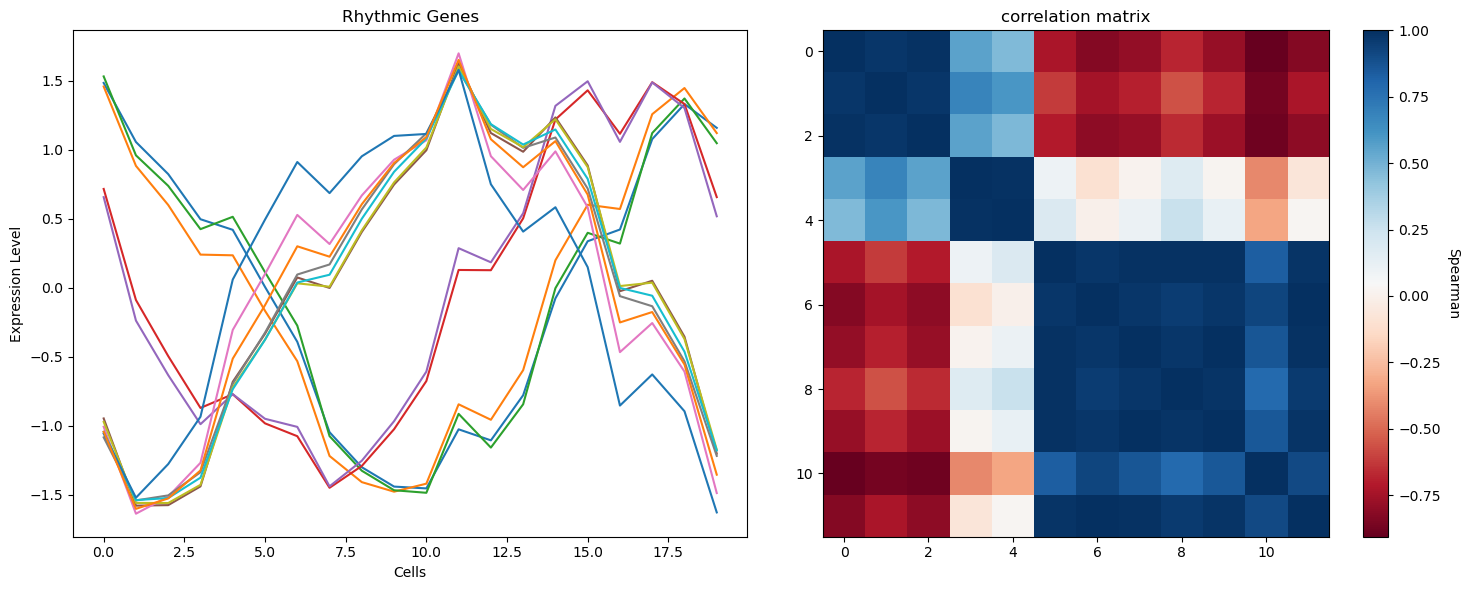

In [10]:
import scipy
emat = adata2.X.T[n_genes:n_genes + n_new_genes,:]
# np.savetxt("/Users/henryhollis/Desktop/noise_matrix.csv", emat, delimiter=",")

# Create a figure with two subplots (1 row, 2 columns)
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Plot rhythmic genes
axes[0].set_title('Rhythmic Genes')
for i in range(0,12):
    axes[0].plot( emat[i, :], label=f'Gene_{i + 1}')
axes[0].set_xlabel('Cells')
axes[0].set_ylabel('Expression Level')

# Plot correlation matrix:
corr_mat = np.array(scipy.stats.spearmanr(emat.T))[0,:,:]

axes[1].set_title('correlation matrix')
im = axes[1].imshow(corr_mat, cmap = "RdBu")
# Add the color bar
cbar = axes[1].figure.colorbar(im, ax = axes[1])
#axes[1].legend()
cbar.ax.set_ylabel("Spearman", rotation = -90, va = "bottom")

plt.tight_layout()

# Show the plot
plt.show()


**Show Reference Matrix**

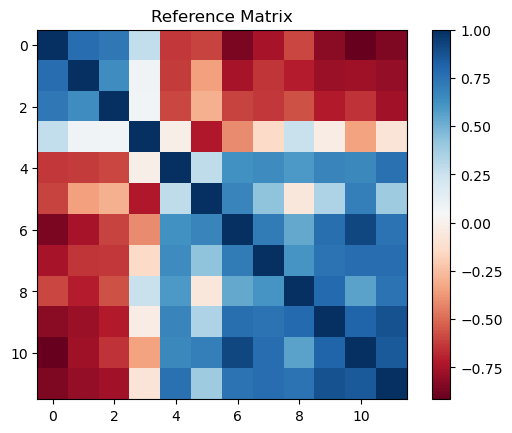

CCD: 3.5747246851643144
3.5747246851643144


In [11]:
import math
refmat = np.array([[1,	0.7754709,	0.72492855,	0.27817942,	0.3,	-0.60375141,	-0.8614806,	-0.7471112,	-0.59455286,	-0.8234182,	-0.9146447,	-0.847398],
                    [0.7754709,	1,	0.63439613,	0.07402797,	0.07,	-0.3498755,	-0.7461844,	-0.645078,	-0.70865725,	-0.784541,	-0.7654845,	-0.7983427],
                    [0.7249286,	0.63439613,	1,	0.06541974,	0.05,	-0.30024636,	-0.6031795,	-0.6364953,	-0.56958405,	-0.7144612,	-0.6455111,	-0.7595101],
                    [0.2781794,	0.07402797,	0.06541974,	1,	0.8,	-0.72253596,	-0.4099044,	-0.1411756,	0.25538496,	-0.0252816,	-0.3401805,	-0.0781101],
                    [0.3,	0.07,	0.05,	0.8,	1,	-0.7,	-0.5,	-0.1,	0.05,	0.1,	-0.3,	0.01],
                    [-0.6037514,	-0.3498755,	-0.30024636,	-0.72253596,	-0.7,	1,	0.6772739,	0.4242223,	-0.06776682,	0.3366267,	0.6955807,	0.3810191],
                    [-0.8614806,	-0.74618443,	-0.60317949,	-0.40990436,	-0.5,	0.67727389,	1,	0.7132144,	0.52923596,	0.7673822,	0.9111478,	0.7487607],
                    [-0.7471112,	-0.64507795,	-0.6364953,	-0.14117556,	-0.1,	0.42422234,	0.7132144,	1,	0.6079441,	0.7467579,	0.7732704,	0.7756198],
                    [-0.5945529,	-0.70865725,	-0.56958405,	0.25538496,	0.05,	-0.06776682,	0.529236,	0.6079441,	1,	0.7868302,	0.5543211,	0.7530874],
                    [-0.8234182,	-0.78454102,	-0.71446119,	-0.0252816,	0.1,	0.33662668,	0.7673822,	0.7467579,	0.78683019,	1,	0.8117621,	0.8738338],
                    [-0.9146447,	-0.76548454,	-0.64551113,	-0.34018047,	-0.3,	0.69558073,	0.9111478,	0.7732704,	0.55432112,	0.8117621,	1,	0.8443479],
                    [-0.847398,	-0.79834269,	-0.75951011,	-0.0781101,	0.01,	0.38101906,	0.7487607,	0.7756198,	0.7530874,	0.8738338,	0.8443479,	1]])

# refmat = corr_mat + np.random.normal(0, .1, (12, 12))
refmat = np.array([[1.0000000,  0.77547090,  0.72492855,  0.27817942, -0.63637681, -0.60375141, -0.8614806, -0.7471112, -0.59455286, -0.8234182, -0.9146447, -0.8473980],
                        [0.7754709,  1.00000000,  0.63439613,  0.07402797, -0.62632300, -0.34987550, -0.7461844, -0.6450780, -0.70865725, -0.7845410, -0.7654845, -0.7983427],
                        [0.7249286,  0.63439613,  1.00000000,  0.06541974, -0.59727560, -0.30024636, -0.6031795, -0.6364953, -0.56958405, -0.7144612, -0.6455111, -0.7595101],
                        [0.2781794,  0.07402797,  0.06541974,  1.00000000, -0.01245765, -0.72253596, -0.4099044, -0.1411756,  0.25538496, -0.0252816, -0.3401805, -0.0781101],
                        [-0.6363768, -0.62632300, -0.59727560, -0.01245765,  1.00000000,  0.28367324,  0.6234166,  0.6454257,  0.59510653,  0.6712806,  0.6618797,  0.7597038],
                        [-0.6037514, -0.34987550, -0.30024636, -0.72253596,  0.28367324,  1.00000000,  0.6772739,  0.4242223, -0.06776682,  0.3366267,  0.6955807,  0.3810191],
                        [-0.8614806, -0.74618443, -0.60317949, -0.40990436,  0.62341661,  0.67727389,  1.0000000,  0.7132144,  0.52923596,  0.7673822,  0.9111478,  0.7487607],
                        [-0.7471112, -0.64507795, -0.63649530, -0.14117556,  0.64542570,  0.42422234,  0.7132144,  1.0000000,  0.60794410,  0.7467579,  0.7732704,  0.7756198],
                        [-0.5945529, -0.70865725, -0.56958405,  0.25538496,  0.59510653, -0.06776682,  0.5292360,  0.6079441,  1.00000000,  0.7868302,  0.5543211,  0.7530874],
                        [-0.8234182, -0.78454102, -0.71446119, -0.02528160,  0.67128060,  0.33662668,  0.7673822,  0.7467579,  0.78683019,  1.0000000,  0.8117621,  0.8738338],
                        [-0.9146447, -0.76548454, -0.64551113, -0.34018047,  0.66187971,  0.69558073,  0.9111478,  0.7732704,  0.55432112,  0.8117621,  1.0000000,  0.8443479],
                        [-0.8473980, -0.79834269, -0.75951011, -0.07811010,  0.75970381,  0.38101906,  0.7487607,  0.7756198,  0.75308740,  0.8738338,  0.8443479,  1.0000000]])

plt.imshow( refmat, cmap = "RdBu" )
plt.colorbar()
plt.title( "Reference Matrix" )
plt.show()
# print(emat)
print("CCD: {}".format(leidenalg.calcCCD(refmat, emat)))
def calcDist(r1, r2):
    tmp = r1-r2
    tmp = tmp ** 2
    return(math.sqrt(np.sum(tmp)))
def calcCCDsimple(ref, emat):
    upper_ref = np.triu(ref)
    corr_mat = np.array(scipy.stats.spearmanr(emat.T))[0,:,:]
    upper_corrmat = np.triu(corr_mat)
    return(calcDist(upper_corrmat, upper_ref))

print(calcCCDsimple(refmat, emat))

In [ ]:
_, G2 = cluster_louvain(adata2, emat, refmat, partition_type= louvain.ModularityVertexPartition)  # You can adjust the 'resolution' parameter
membership_louvainStock = [int(i) for i in adata2.obs['louvainccd'].to_list()]
# _plot(G2, membership_louvainStock, draw = "kk")

: 

In [14]:
# Perform Louvain clustering
_, G = cluster_louvain(adata2, emat, refmat, partition_type= louvain.ccdModularityVertexPartition)
membership = [int(i) for i in adata2.obs['louvainccd'].to_list()]
# _plot(G, membership, draw = "kk")


No subject information provided. Assuming each col in emat is independent subject.
Using partition class:  <class 'louvain.VertexPartition.ccdModularityVertexPartition'>
Processing ccdModularityVertexPartition instance


/opt/miniconda3/envs/native/lib/python3.12/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/opt/miniconda3/envs/native/lib/python3.12/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/opt/miniconda3/envs/native/lib/python3.12/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/opt

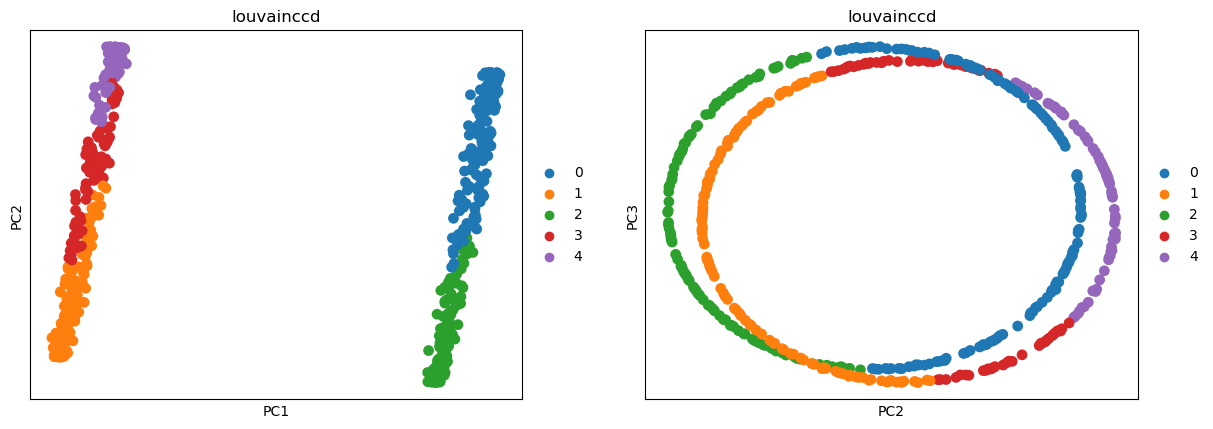

/opt/miniconda3/envs/native/lib/python3.12/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/opt/miniconda3/envs/native/lib/python3.12/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


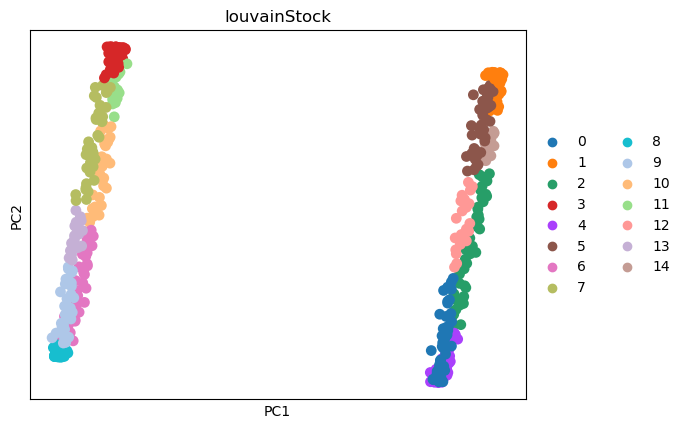

/opt/miniconda3/envs/native/lib/python3.12/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/opt/miniconda3/envs/native/lib/python3.12/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/opt/miniconda3/envs/native/lib/python3.12/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/opt

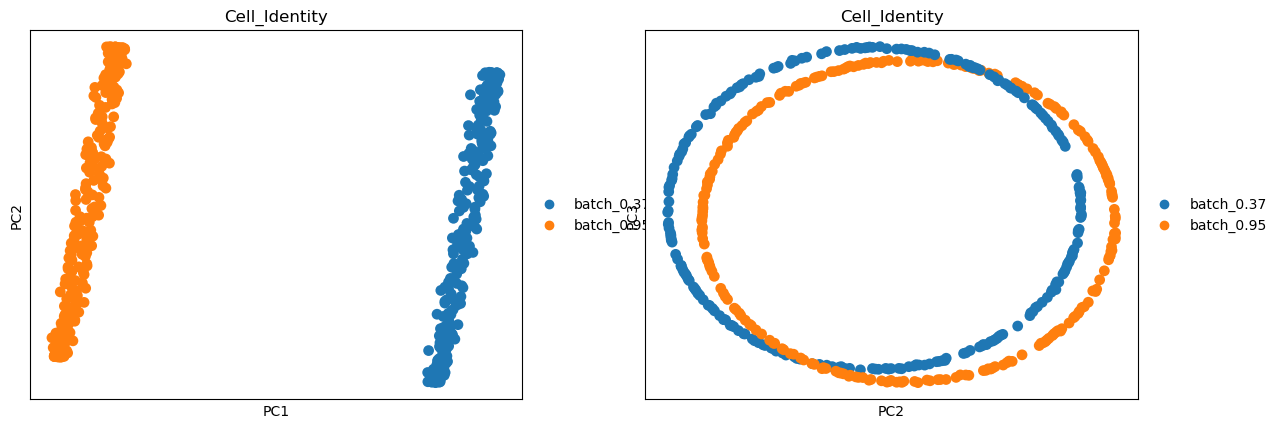

In [15]:
# Assuming you have an 'adata' object with Louvain cluster assignments

# Calculate UMAP
sc.tl.umap(adata2)

# Plot UMAP with Louvain clusters
# sc.pl.umap(adata2, color='louvainccd', legend_loc='on data')
# sc.pl.umap(adata2, color='Cell_Identity', legend_loc='on data')
sc.pl.pca(adata2, color= 'louvainccd' , components = ['1,2', '2,3'], show=True)
adata2.obs['louvainStock'] = [str(i) for i in membership_louvainStock]
sc.pl.pca(adata2, color = 'louvainStock', show = True)
sc.pl.pca(adata2, color='Cell_Identity', components=pcs_to_plot, show=True)


In [18]:
clusterA = 3
clusterB = 4
cluster_A_cells = [i for i in range(len(membership)) if membership[i] == clusterA]
print(cluster_A_cells)  

cluster_B_cells = [i for i in range(len(membership)) if membership[i] == clusterB]
print(cluster_B_cells)  
cluster_A_emat = adata2.X.T[n_genes:n_genes + n_new_genes,cluster_A_cells]
cluster_B_emat = adata2.X.T[n_genes:n_genes + n_new_genes,cluster_B_cells]

cluster_A_ccd = leidenalg.calcCCD(refmat, cluster_A_emat)
cluster_B_ccd = leidenalg.calcCCD(refmat, cluster_B_emat)

combined_emat = np.concatenate(( cluster_A_emat, cluster_B_emat), axis = 1)
combined_ccd = leidenalg.calcCCD(refmat, combined_emat)
print("cluster {} ccd {:.3f}".format(clusterA, cluster_A_ccd))
print("cluster {} ccd {:.3f}".format(clusterB, cluster_B_ccd))
print("{} & {} ccd {:.3f}".format(clusterA, clusterB, combined_ccd))

emat = adata2.X.T[n_genes:n_genes + n_new_genes,:]
# List of indices for coloring points
# This list should be of the same length as the number of points to plot
color_indices = membership

# # Create a colormap
# colors = np.array(['red', 'green', 'blue', 'purple'])
# point_colors = colors[color_indices]
# # Get the number of rows and columns in emat
# num_rows, num_cols = emat.shape
# print("num rows: {}".format(num_rows), "num cols: {}".format(num_cols))
# # Create a figure and axis
# fig, ax = plt.subplots()
# # Plot each row of emat
# for i in range(num_rows):
#     x = np.arange(num_cols)  # Column indices
#     y = emat[i, :]  # Each row of emat
#     ax.scatter(x, y, c= point_colors, label=f'Row {i+1}')

# # Add labels and title
# ax.set_xlabel('Cell')
# ax.set_ylabel('Expression')
# ax.set_title('Scatter Plot of emat Rows with Colored Points')


[24, 28, 29, 30, 31, 32, 33, 35, 36, 37, 38, 39, 40, 48, 53, 54, 55, 57, 60, 61, 62, 63, 64, 65, 71, 72, 74, 76, 80, 82, 83, 314, 315, 317, 319, 320, 321, 322, 323, 325, 327, 328, 329, 330, 332, 334, 335, 337, 340, 345, 346, 348, 350, 351, 352, 354, 356, 360, 362, 363, 365, 367, 369, 370, 371, 372, 373, 376, 379, 380]
[0, 4, 5, 6, 11, 14, 15, 17, 18, 20, 21, 388, 389, 390, 391, 393, 397, 398, 403, 404, 407, 408, 410, 411, 412, 418, 421, 423, 426, 428, 429, 433, 434, 437, 439, 440, 441, 442, 443, 444, 445, 446, 447, 448, 449, 450, 451, 455, 456, 457, 458, 464, 467, 468, 471, 475, 476, 477, 478, 479, 483, 484, 485, 487, 488, 489, 495]
cluster 3 ccd 3.418
cluster 4 ccd 3.803
3 & 4 ccd 3.786
